# Importuri

In [25]:
#!pip install monai --upgrade

In [26]:
import os
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import shutil
import numpy as np
import torch
import random
import torch.nn as nn
import torch.optim as optim
import monai
from monai.transforms import Compose, RandFlip, RandRotate, RandZoom, NormalizeIntensity
from monai.transforms import SpatialCropd
from sklearn.model_selection import StratifiedKFold
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from torchvision import models as torch_models, transforms
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score, f1_score)
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision.models import ResNet18_Weights
from torch.utils.data import WeightedRandomSampler, Subset
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, RandomCrop
from sklearn.utils.class_weight import compute_class_weight

# Cerinta 1 Etapa 1
Clasa personalizata

In [2]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None, data=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = data or []
        self.label_map = {}

        if not data:
            categories = sorted(os.listdir(root_dir))
            for label, category in enumerate(categories):
                category_path = os.path.join(root_dir, category)
                if os.path.isdir(category_path):
                    self.label_map[label] = category
                    for filename in os.listdir(category_path):
                        file_path = os.path.join(category_path, filename)
                        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                            self.data.append((file_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path, label = self.data[idx]
        image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

        if self.transform:
            image = Image.fromarray(image)
            image = self.transform(image)
        else:
            image = torch.tensor(image, dtype=torch.float32).unsqueeze(0) / 255.0

        return image, label

# Cerinta 2 Etapa 1
metoda de impartire a setului de date de antrenare

In [3]:
def split_dataset_with_sklearn(dataset, train_size=0.8, random_seed=42):
    data = dataset.data

    train_data, val_data = train_test_split(
        data, train_size=train_size, random_state=random_seed, stratify=[label for _, label in data]
    )

    train_dataset = BrainTumorDataset(root_dir=dataset.root_dir, transform=dataset.transform, data=train_data)
    val_dataset = BrainTumorDataset(root_dir=dataset.root_dir, transform=dataset.transform, data=val_data)

    train_dataset.label_map = dataset.label_map
    val_dataset.label_map = dataset.label_map

    return train_dataset, val_dataset

# Cerinta 3 Etapa 1
metoda de vizualizare a distributiei claselor

In [5]:
def plot_class_distribution(dataset, title):
    labels = [label for _, label in dataset]
    class_counts = Counter(labels)

    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.title(title)
    plt.xlabel("Categorie")
    plt.ylabel("Număr de imagini")
    plt.xticks(rotation=45)
    plt.show()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

arhiva = '/content/archive.zip'

destinatie = '/content/'

shutil.unpack_archive(arhiva, destinatie)

dataset = BrainTumorDataset(root_dir="Training", transform=transform)

train_subset, val_subset = split_dataset_with_sklearn(dataset, train_size=0.8)

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=False)

#plot_class_distribution(dataset, "Distribuția claselor în setul de date")
#plot_class_distribution(val_subset, "Distribuția claselor în setul de validare")
#plot_class_distribution(train_subset, "Distribuția claselor în setul de antrenare")

# Cerinta 4 Etapa 1


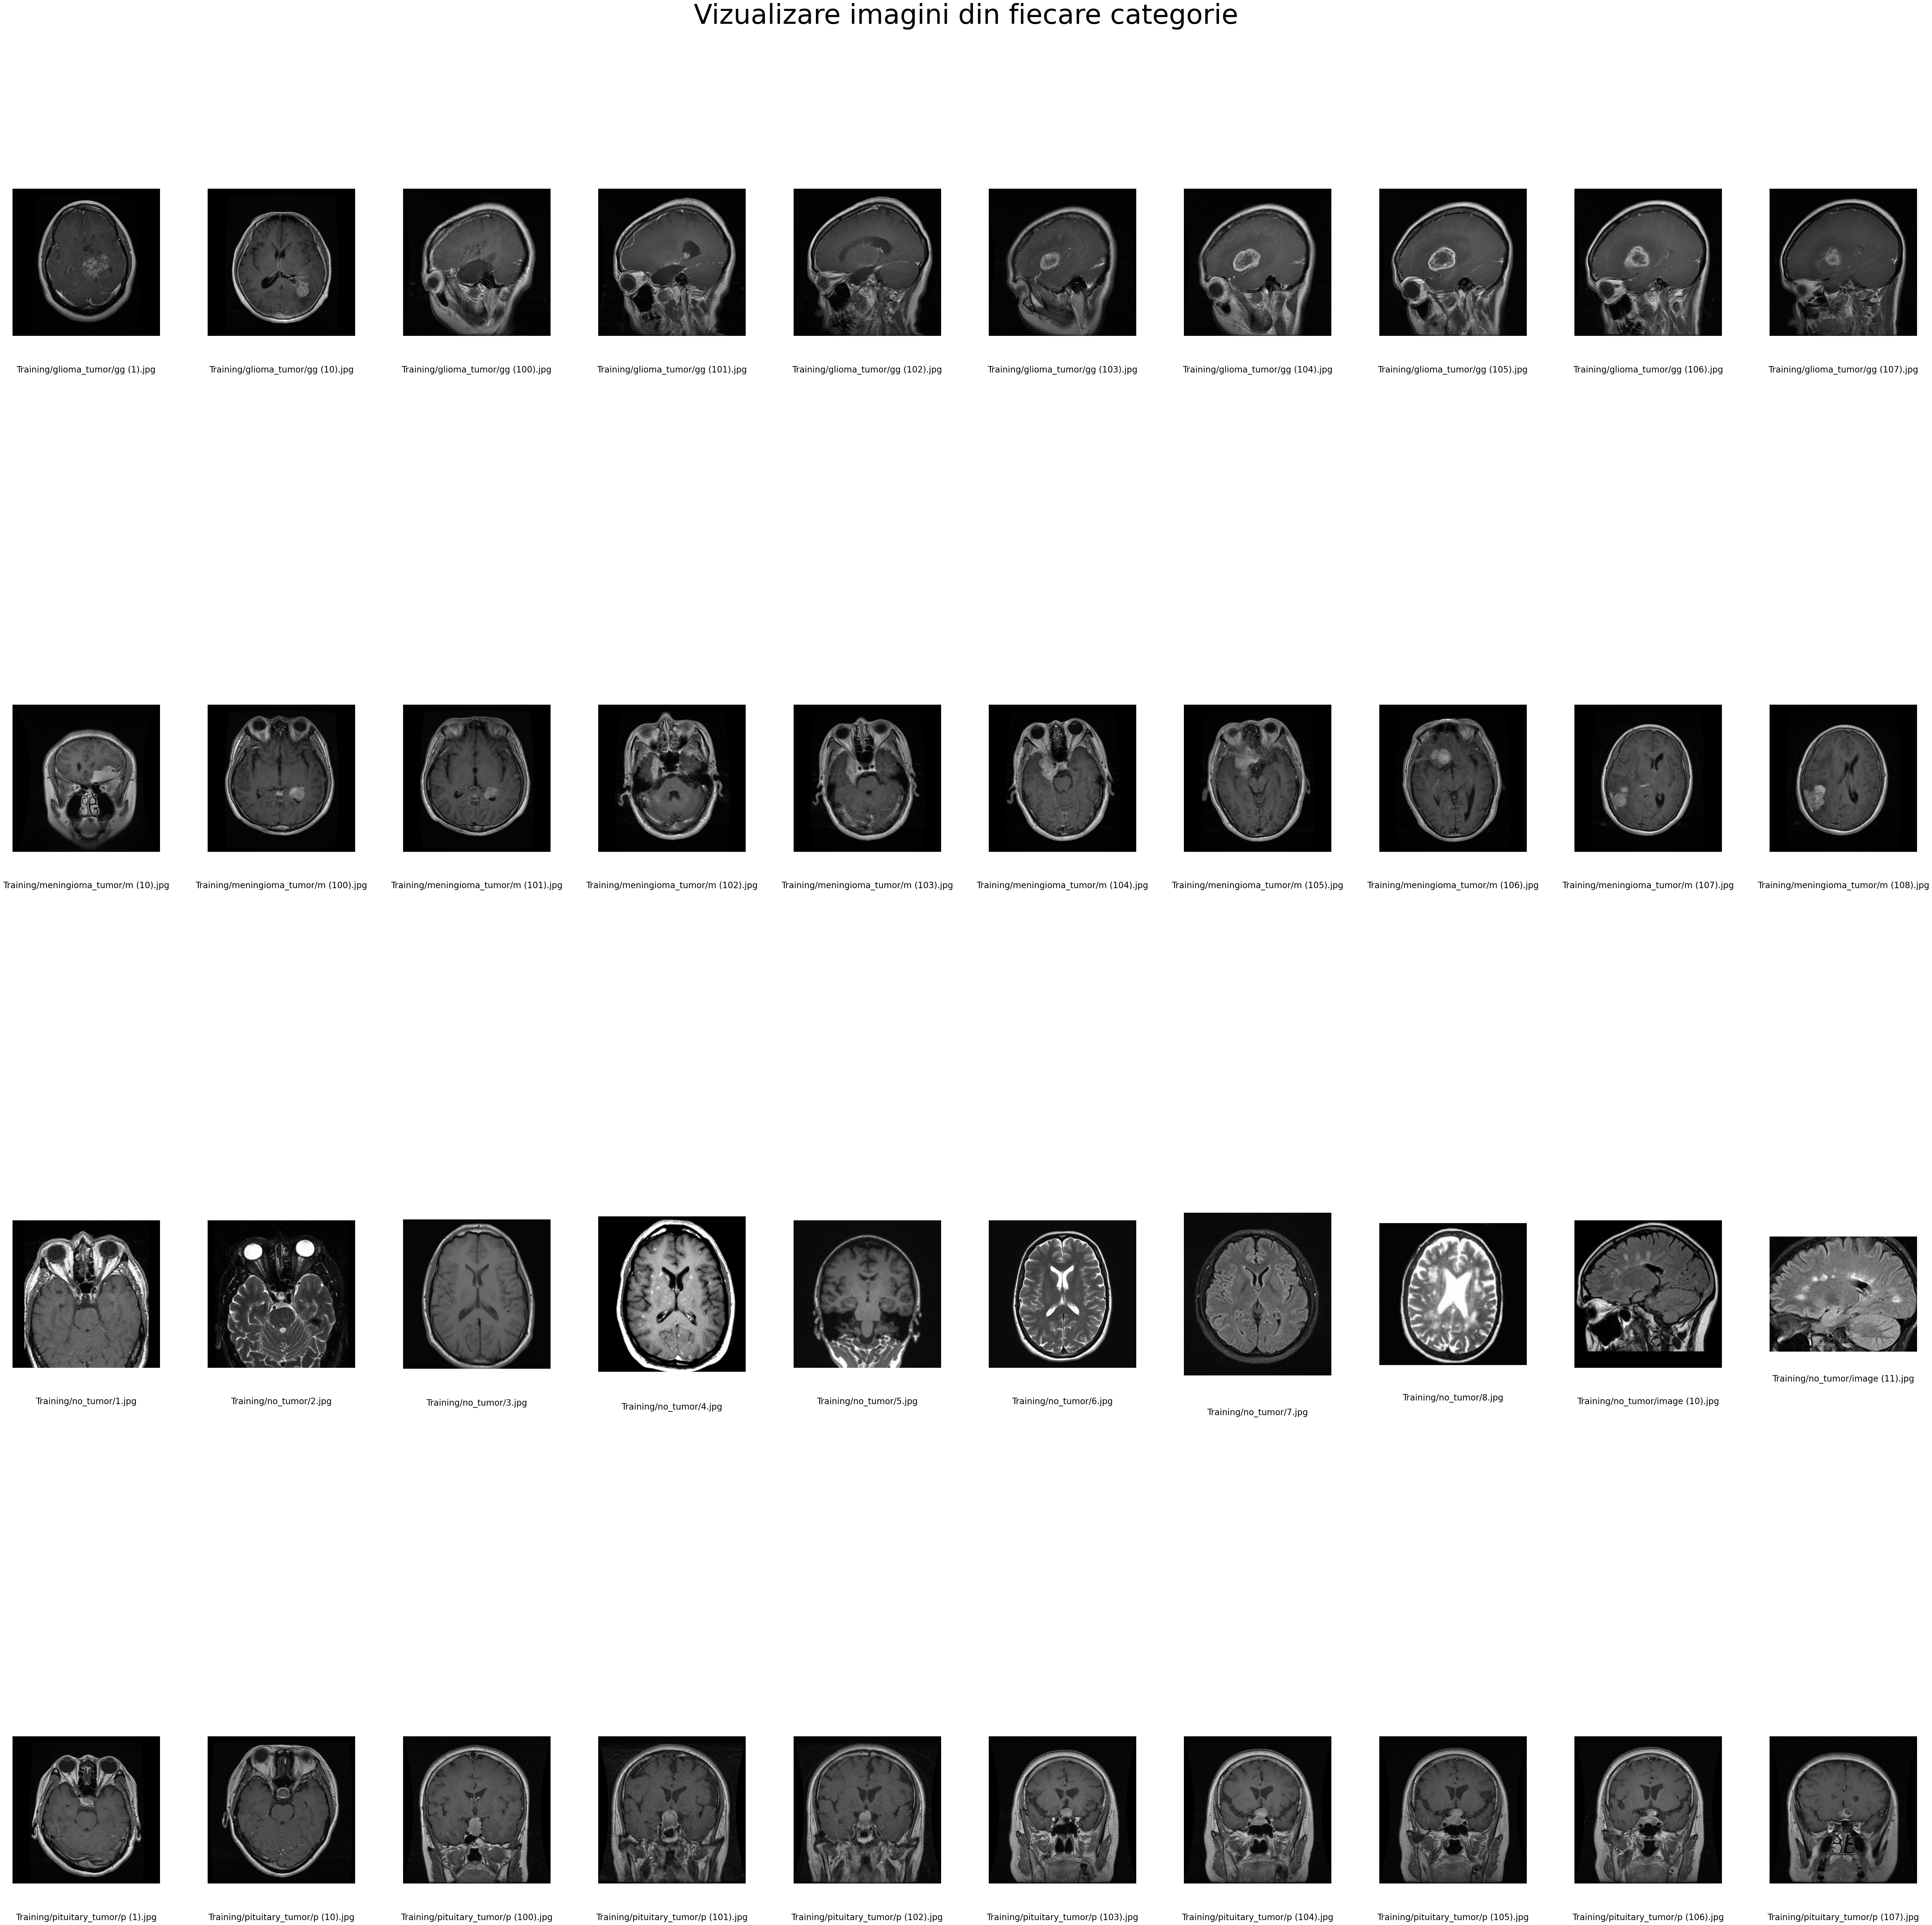

In [6]:
def visualize_categories(dataset, num_images=5):
    # Sortăm datele după categorie și apoi după calea fișierului
    sorted_data = sorted(dataset.data, key=lambda x: (dataset.label_map[x[1]], x[0]))

    # Grupăm imaginile pe categorii
    categories = {label: [] for label in dataset.label_map.values()}
    for img_path, label in sorted_data:
        label_str = dataset.label_map[label]
        if len(categories[label_str]) < num_images:
            categories[label_str].append(img_path)

    # Creăm figura pentru afișare
    fig, axes = plt.subplots(len(categories), num_images, figsize=(64, 64))
    fig.suptitle("Vizualizare imagini din fiecare categorie", fontsize=64)

    for row, (category, images) in enumerate(categories.items()):
        for col, img_path in enumerate(images):
            image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            if len(image.shape) == 2:
                cmap = 'spring'
            else:
                cmap = 'spring'

            ax = axes[row, col]
            ax.imshow(image, cmap=cmap)
            ax.axis("off")

            # Adăugăm calea imaginii sub fiecare imagine
            ax.text(0.5, -0.2, img_path, fontsize=20, ha="center", va="top", wrap=True, transform=ax.transAxes)

        # Adăugăm titlul categoriei pe rând
        axes[row, 0].set_ylabel(category, fontsize=32, rotation=90, labelpad=10)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9, hspace=1.5)  # Ajustăm spațiul pentru text
    plt.show()

# Exemplu de apelare
visualize_categories(dataset, num_images=10)

### Definirea modelului

In [7]:
def build_resnet(num_classes):
    model = torch_models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

    for param in model.parameters():
        param.requires_grad = False

    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    return model

### Functia de antrenare

In [8]:
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001, device="cuda"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct.double() / len(train_loader.dataset)
        print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}")

        model.eval()
        val_loss = 0.0
        val_correct = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct.double() / len(val_loader.dataset)
        print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_acc:.4f}")

    return model

### Evaluarea si matricea de confuzie

In [9]:
def evaluate_model(model, dataloader, label_map, device="cuda"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Raportul de clasificare:")
    print(classification_report(all_labels, all_preds, target_names=list(label_map.values()), digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, list(label_map.values()))

In [10]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Etichete prezise")
    plt.ylabel("Etichete reale")
    plt.title("Matricea de confuzie")
    plt.show()

### Modelul in sine

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

dataset = BrainTumorDataset(root_dir="Training", transform=transform)
train_subset, val_subset = split_dataset_with_sklearn(dataset, train_size=0.8)

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

In [ ]:
num_classes = len(dataset.label_map)
model = build_resnet(num_classes)
model = train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001, device=device)

torch.save(model.state_dict(), "resnet_brain_tumor.pth")
print("Model salvat ca resnet_brain_tumor.pth")

evaluate_model(model, val_loader, dataset.label_map, device=device)

#Cerinta 1 Etapa 2

### Functia de k-fold cross validation

In [50]:
def k_fold_cross_validation(dataset, k=5, num_epochs=10, learning_rate=0.001, batch_size=32, device="cuda", use_augmentation=False):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    data = dataset.data
    X = [item[0] for item in data]
    y = [item[1] for item in data]

    fold_metrics = {
        "val": {"accuracy": [], "precision": [], "recall": [], "f1_score": []},
        "test": {"accuracy": [], "precision": [], "recall": [], "f1_score": []},
    }

    test_subset = None
    if use_augmentation:
        transform_set1 = Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229]),
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip()
        ])

        transform_set2 = Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229]),
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomCrop((224, 224),2)
        ])

        transform_set3 = Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomCrop((224, 224),2),
        ])

        for augment_set_idx, transform in enumerate([transform_set1, transform_set2, transform_set3]):
            print(f"\n=== Setul de Augmentări {augment_set_idx + 1} ===")

            for fold_idx, (train_val_idx, test_idx) in enumerate(skf.split(X, y)):
                print(f"\n=== Fold {fold_idx + 1}/{k} ===")

                train_val_data = [data[i] for i in train_val_idx]
                test_data = [data[i] for i in test_idx]

                train_idx, val_idx = train_test_split(
                    range(len(train_val_data)),
                    train_size=0.8,
                    stratify=[label for _, label in train_val_data],
                    random_state=42,
                )
                train_data = [train_val_data[i] for i in train_idx]
                val_data = [train_val_data[i] for i in val_idx]

                train_dataset = BrainTumorDataset(dataset.root_dir, transform=transform, data=train_data)
                val_dataset = BrainTumorDataset(dataset.root_dir, transform=transform, data=val_data)
                test_subset = BrainTumorDataset(dataset.root_dir, transform=transform, data=test_data)

                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
                test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

                num_classes = len(dataset.label_map)
                model = build_resnet(num_classes).to(device)

                history = train_model_with_history(model, train_loader, val_loader, num_epochs, learning_rate, device)
                plot_training_history(history, fold_idx + 1, augment_set_idx + 1)

                val_metrics = evaluate_model_metrics(model, val_loader, dataset.label_map, device)
                for metric, value in val_metrics.items():
                    fold_metrics["val"][metric].append(value)


                test_metrics = evaluate_model_metrics(model, test_loader, dataset.label_map, device)
                for metric, value in test_metrics.items():
                    fold_metrics["test"][metric].append(value)

    else:

        print("\n=== Fără Augmentări ===")

        for fold_idx, (train_val_idx, test_idx) in enumerate(skf.split(X, y)):
            print(f"\n=== Fold {fold_idx + 1}/{k} ===")


            train_val_data = [data[i] for i in train_val_idx]
            test_data = [data[i] for i in test_idx]


            train_idx, val_idx = train_test_split(
                range(len(train_val_data)),
                train_size=0.8,
                stratify=[label for _, label in train_val_data],
                random_state=42,
            )
            train_data = [train_val_data[i] for i in train_idx]
            val_data = [train_val_data[i] for i in val_idx]

            transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485], std=[0.229])
            ])

            train_dataset = BrainTumorDataset(dataset.root_dir, transform=transform, data=train_data)
            val_dataset = BrainTumorDataset(dataset.root_dir, transform=transform, data=val_data)
            test_subset = BrainTumorDataset(dataset.root_dir, transform=transform, data=test_data)

            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
            test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

            num_classes = len(dataset.label_map)
            model = build_resnet(num_classes).to(device)

            history = train_model_with_history(model, train_loader, val_loader, num_epochs, learning_rate, device)
            plot_training_history(history, fold_idx + 1)

            val_metrics = evaluate_model_metrics(model, val_loader, dataset.label_map, device)
            for metric, value in val_metrics.items():
                fold_metrics["val"][metric].append(value)

            test_metrics = evaluate_model_metrics(model, test_loader, dataset.label_map, device)
            for metric, value in test_metrics.items():
                fold_metrics["test"][metric].append(value)

    print("\n=== Rezumatul K-Fold ===")
    for phase in ["val", "test"]:
        print(f"\nMetrici pentru {phase.upper()}:")
        for metric, values in fold_metrics[phase].items():
            mean = np.mean(values)
            std = np.std(values)
            print(f"{metric.capitalize()}: Media = {mean:.4f}, Deviația standard = {std:.4f}")


### Functia de antrenare cu istoric

In [14]:
def train_model_with_history(model, train_loader, val_loader, num_epochs, learning_rate, device="cuda", criterion=None):
    criterion = criterion or nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        correct = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct.double() / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct.double() / len(val_loader.dataset)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc.item())
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc.item())

        print(
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

    return history

### Functia de plot de cu istoric

In [28]:
def plot_training_history(history, fold_idx, augument_set_idx=0):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Pierdere antrenare")
    plt.plot(history["val_loss"], label="Pierdere validare")
    plt.title("Evoluția pierderii")
    plt.xlabel("Epoca")
    plt.ylabel("Pierdere")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Acuratețe antrenare")
    plt.plot(history["val_acc"], label="Acuratețe validare")
    plt.title("Evoluția acurateței")
    plt.xlabel("Epoca")
    plt.ylabel("Acuratețe")
    plt.legend()

    if augument_set_idx != 0:
        plt.suptitle(f"Evoluția metricilor pentru Fold {fold_idx} și Setul de Augmentare {augument_set_idx}")
        plt.tight_layout()
        plt.savefig(f"fold_{fold_idx}_metrics_augument{augument_set_idx}.png")
        plt.show()
    else:
        plt.suptitle(f"Evoluția metricilor pentru Fold {fold_idx}")
        plt.tight_layout()
        plt.savefig(f"fold_{fold_idx}_metrics.png")
        plt.show()

### Evaluare metricilor

In [30]:
def evaluate_model_metrics(model, dataloader, label_map, device="cuda"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1}


=== Fold 1/5 ===


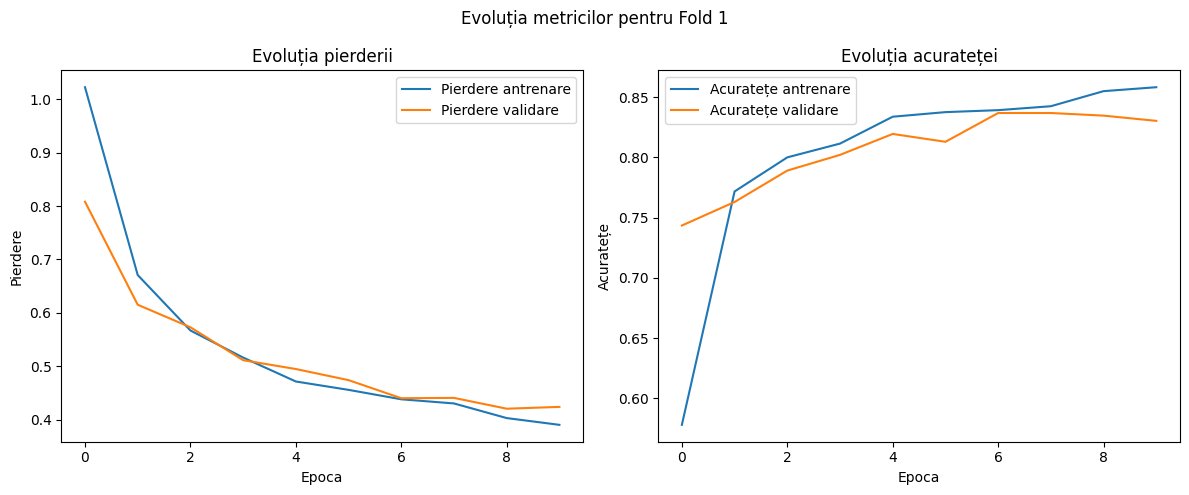


=== Fold 2/5 ===



=== Fold 3/5 ===



=== Fold 4/5 ===


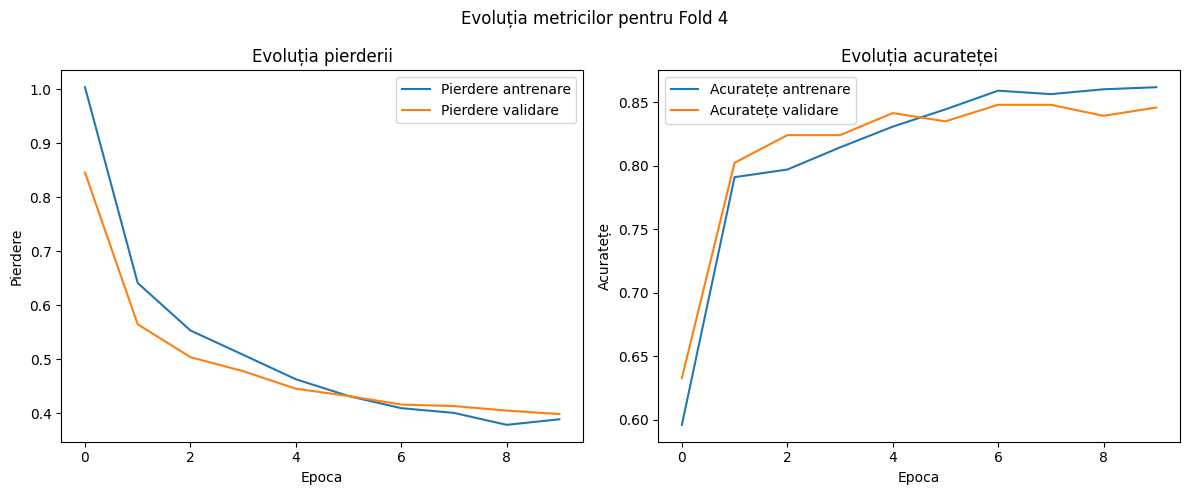


=== Fold 5/5 ===


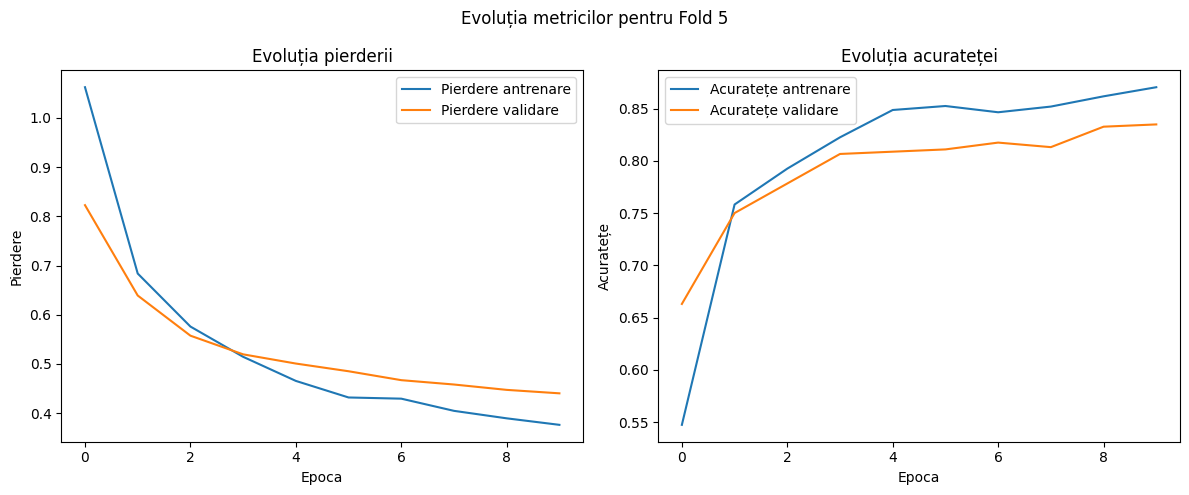


=== Rezumatul K-Fold ===

Metrici pentru VAL:
Accuracy: Media = 0.8448, Deviația standard = 0.0121
Precision: Media = 0.8495, Deviația standard = 0.0145
Recall: Media = 0.8448, Deviația standard = 0.0121
F1_score: Media = 0.8441, Deviația standard = 0.0143

Metrici pentru TEST:
Accuracy: Media = 0.8369, Deviația standard = 0.0115
Precision: Media = 0.8388, Deviația standard = 0.0125
Recall: Media = 0.8369, Deviația standard = 0.0115
F1_score: Media = 0.8362, Deviația standard = 0.0119


In [ ]:
k_fold_cross_validation(dataset, k=5, num_epochs=10, learning_rate=0.001, batch_size=32, device="cuda")

#Cerinta 2 Etapa 2

In [17]:
def compute_class_weights(dataset):
    labels = [label for _, label in dataset.data]
    class_weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels)
    return torch.tensor(class_weights, dtype=torch.float)

###Functie de augumentare a datelor

In [18]:
def augment_data(dataset, label_map, transform=None):
    augmented_data = []
    class_counts = Counter([label for _, label in dataset.data])
    max_count = max(class_counts.values())

    for label, count in class_counts.items():
        deficit = max_count - count
        examples = [item for item in dataset.data if item[1] == label]

        for _ in range(deficit):
            img_path, label = random.choice(examples)
            image = Image.open(img_path)
            if transform:
                image = transform(image)

            augmented_data.append((img_path, label))
    augmented_dataset = BrainTumorDataset(
        dataset.root_dir,
        transform=dataset.transform,
        data=dataset.data + augmented_data,
    )
    augmented_dataset.label_map = dataset.label_map
    return augmented_dataset

###Functia de antrenare si evaluare

In [19]:
def train_and_evaluate(dataset, num_epochs=10, batch_size=32, learning_rate=0.001, device="cuda"):
    print("\n=== Fără metode de balansare ===")
    train_dataset, val_dataset = split_dataset_with_sklearn(dataset, train_size=0.8)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = build_resnet(len(dataset.label_map)).to(device)
    history_no_balance = train_model_with_history(model, train_loader, val_loader, num_epochs, learning_rate, device)
    val_metrics_no_balance = evaluate_model_metrics(model, val_loader, dataset.label_map, device)

    print("\n=== Funcția de pierdere cu ponderi ===")
    class_weights = compute_class_weights(dataset).to(device)
    weighted_criterion = nn.CrossEntropyLoss(weight=class_weights)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = build_resnet(len(dataset.label_map)).to(device)
    history_weighted_loss = train_model_with_history(
        model, train_loader, val_loader, num_epochs, learning_rate, device, criterion=weighted_criterion
    )
    val_metrics_weighted_loss = evaluate_model_metrics(model, val_loader, dataset.label_map, device)

    print("\n=== Oversampling fără augmentare ===")
    labels = [label for _, label in train_dataset.data]
    class_sample_counts = Counter(labels)
    sample_weights = [1.0 / class_sample_counts[label] for _, label in train_dataset.data]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_dataset), replacement=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = build_resnet(len(dataset.label_map)).to(device)
    history_oversampling = train_model_with_history(model, train_loader, val_loader, num_epochs, learning_rate, device)
    val_metrics_oversampling = evaluate_model_metrics(model, val_loader, dataset.label_map, device)

    print("\n=== Oversampling cu augmentare ===")
    augmentation_transform = transforms.Compose([
        RandomHorizontalFlip(),
        RandomRotation(10),
    ])
    augmented_dataset = augment_data(train_dataset, dataset.label_map, transform=augmentation_transform)
    train_loader = DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True)

    model = build_resnet(len(dataset.label_map)).to(device)
    history_augmented_oversampling = train_model_with_history(model, train_loader, val_loader, num_epochs, learning_rate, device)
    val_metrics_augmented_oversampling = evaluate_model_metrics(model, val_loader, dataset.label_map, device)

    print("\n=== Comparare Performanțe ===")
    results = {
        "No Balancing": val_metrics_no_balance,
        "Weighted Loss": val_metrics_weighted_loss,
        "Oversampling": val_metrics_oversampling,
        "Augmented Oversampling": val_metrics_augmented_oversampling,
    }
    for method, metrics in results.items():
        print(f"\n{method}:")
        for metric, value in metrics.items():
            print(f"{metric.capitalize()}: {value:.4f}")

In [ ]:
train_and_evaluate(dataset, num_epochs=10, batch_size=32, learning_rate=0.001, device="cuda")


=== Fără metode de balansare ===
Epoch 1/10
Train Loss: 0.9843, Train Acc: 0.6067, Val Loss: 0.6827, Val Acc: 0.7875
Epoch 2/10
Train Loss: 0.6324, Train Acc: 0.7809, Val Loss: 0.5064, Val Acc: 0.8467
Epoch 3/10
Train Loss: 0.5263, Train Acc: 0.8136, Val Loss: 0.4540, Val Acc: 0.8449
Epoch 4/10
Train Loss: 0.5120, Train Acc: 0.8079, Val Loss: 0.4444, Val Acc: 0.8571
Epoch 5/10
Train Loss: 0.4602, Train Acc: 0.8293, Val Loss: 0.4385, Val Acc: 0.8467
Epoch 6/10
Train Loss: 0.4233, Train Acc: 0.8445, Val Loss: 0.4363, Val Acc: 0.8380
Epoch 7/10
Train Loss: 0.4014, Train Acc: 0.8515, Val Loss: 0.4020, Val Acc: 0.8502
Epoch 8/10
Train Loss: 0.3896, Train Acc: 0.8619, Val Loss: 0.4290, Val Acc: 0.8345
Epoch 9/10
Train Loss: 0.3810, Train Acc: 0.8611, Val Loss: 0.4066, Val Acc: 0.8537
Epoch 10/10
Train Loss: 0.3674, Train Acc: 0.8711, Val Loss: 0.4299, Val Acc: 0.8380

=== Funcția de pierdere cu ponderi ===
Epoch 1/10
Train Loss: 0.9845, Train Acc: 0.6246, Val Loss: 0.7126, Val Acc: 0.7648
E

#Cerinta 3 Etapa 2


=== Setul de Augmentări 1 ===

=== Fold 1/5 ===
Epoch 1/10
Train Loss: 1.0739, Train Acc: 0.5556, Val Loss: 0.9033, Val Acc: 0.6978
Epoch 2/10
Train Loss: 0.7987, Train Acc: 0.6944, Val Loss: 0.7966, Val Acc: 0.6870
Epoch 3/10
Train Loss: 0.7175, Train Acc: 0.7239, Val Loss: 0.6468, Val Acc: 0.7652
Epoch 4/10
Train Loss: 0.6704, Train Acc: 0.7478, Val Loss: 0.6950, Val Acc: 0.7217
Epoch 5/10
Train Loss: 0.6183, Train Acc: 0.7680, Val Loss: 0.5739, Val Acc: 0.7891
Epoch 6/10
Train Loss: 0.5974, Train Acc: 0.7707, Val Loss: 0.5258, Val Acc: 0.7935
Epoch 7/10
Train Loss: 0.5985, Train Acc: 0.7718, Val Loss: 0.5942, Val Acc: 0.7522
Epoch 8/10
Train Loss: 0.5609, Train Acc: 0.7821, Val Loss: 0.5429, Val Acc: 0.7826
Epoch 9/10
Train Loss: 0.5626, Train Acc: 0.7876, Val Loss: 0.5455, Val Acc: 0.7783
Epoch 10/10
Train Loss: 0.5398, Train Acc: 0.8039, Val Loss: 0.5081, Val Acc: 0.8000



=== Fold 2/5 ===
Epoch 1/10
Train Loss: 1.1268, Train Acc: 0.5305, Val Loss: 0.9137, Val Acc: 0.6065
Epoch 2/10
Train Loss: 0.7940, Train Acc: 0.7190, Val Loss: 0.6968, Val Acc: 0.7348
Epoch 3/10
Train Loss: 0.6845, Train Acc: 0.7495, Val Loss: 0.6264, Val Acc: 0.7500
Epoch 4/10
Train Loss: 0.6524, Train Acc: 0.7625, Val Loss: 0.5648, Val Acc: 0.8022
Epoch 5/10
Train Loss: 0.6052, Train Acc: 0.7642, Val Loss: 0.5231, Val Acc: 0.8196
Epoch 6/10
Train Loss: 0.5712, Train Acc: 0.7898, Val Loss: 0.5735, Val Acc: 0.7587
Epoch 7/10
Train Loss: 0.5586, Train Acc: 0.7870, Val Loss: 0.5279, Val Acc: 0.8065
Epoch 8/10
Train Loss: 0.5533, Train Acc: 0.7854, Val Loss: 0.5006, Val Acc: 0.7848
Epoch 9/10
Train Loss: 0.5199, Train Acc: 0.7979, Val Loss: 0.5051, Val Acc: 0.7957
Epoch 10/10
Train Loss: 0.5303, Train Acc: 0.7936, Val Loss: 0.4835, Val Acc: 0.8152


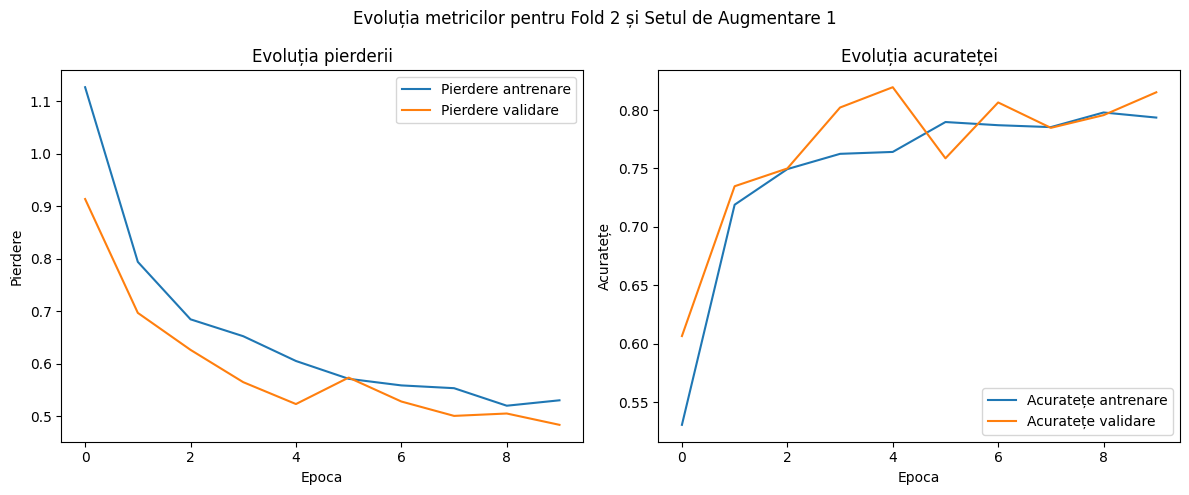


=== Fold 3/5 ===
Epoch 1/10
Train Loss: 1.1219, Train Acc: 0.5251, Val Loss: 0.9395, Val Acc: 0.6457
Epoch 2/10
Train Loss: 0.7944, Train Acc: 0.6993, Val Loss: 0.6995, Val Acc: 0.7674
Epoch 3/10
Train Loss: 0.6714, Train Acc: 0.7554, Val Loss: 0.6214, Val Acc: 0.7696
Epoch 4/10
Train Loss: 0.6276, Train Acc: 0.7680, Val Loss: 0.5951, Val Acc: 0.7783
Epoch 5/10
Train Loss: 0.5918, Train Acc: 0.7756, Val Loss: 0.5511, Val Acc: 0.8000
Epoch 6/10
Train Loss: 0.5646, Train Acc: 0.7832, Val Loss: 0.5685, Val Acc: 0.7826
Epoch 7/10
Train Loss: 0.5696, Train Acc: 0.7805, Val Loss: 0.4883, Val Acc: 0.8283
Epoch 8/10
Train Loss: 0.5430, Train Acc: 0.8007, Val Loss: 0.5775, Val Acc: 0.7500
Epoch 9/10
Train Loss: 0.5313, Train Acc: 0.7990, Val Loss: 0.4933, Val Acc: 0.8130
Epoch 10/10
Train Loss: 0.5190, Train Acc: 0.8072, Val Loss: 0.4594, Val Acc: 0.8413


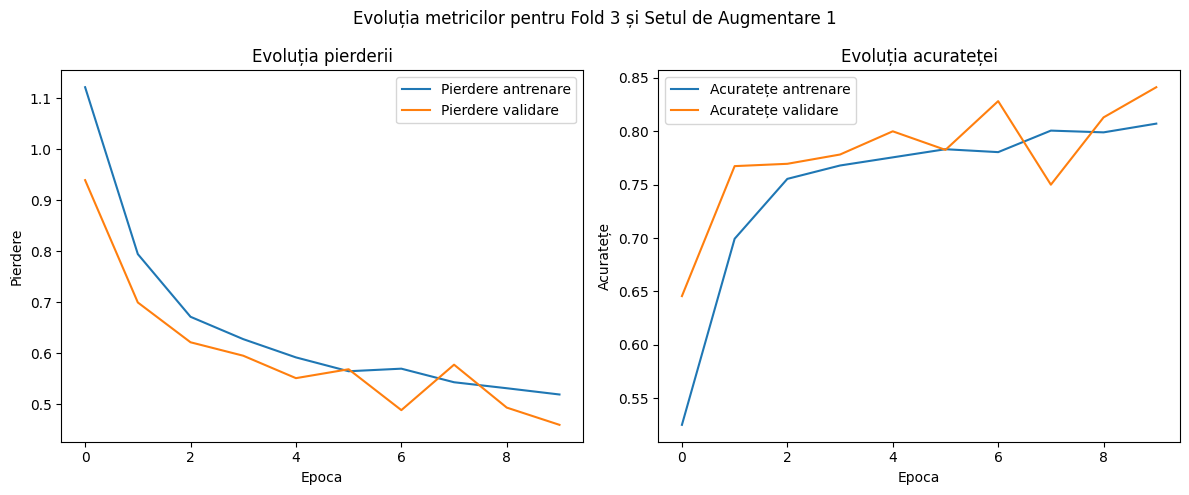


=== Fold 4/5 ===
Epoch 1/10
Train Loss: 1.1125, Train Acc: 0.5354, Val Loss: 0.8872, Val Acc: 0.6739
Epoch 2/10
Train Loss: 0.7971, Train Acc: 0.6999, Val Loss: 0.7183, Val Acc: 0.7413
Epoch 3/10
Train Loss: 0.6796, Train Acc: 0.7386, Val Loss: 0.6179, Val Acc: 0.7739
Epoch 4/10
Train Loss: 0.6561, Train Acc: 0.7478, Val Loss: 0.5802, Val Acc: 0.8022
Epoch 5/10
Train Loss: 0.5849, Train Acc: 0.7865, Val Loss: 0.6108, Val Acc: 0.7783
Epoch 6/10
Train Loss: 0.5620, Train Acc: 0.7849, Val Loss: 0.5390, Val Acc: 0.7978
Epoch 7/10
Train Loss: 0.5521, Train Acc: 0.7919, Val Loss: 0.5386, Val Acc: 0.8152
Epoch 8/10
Train Loss: 0.5475, Train Acc: 0.7898, Val Loss: 0.4998, Val Acc: 0.8239
Epoch 9/10
Train Loss: 0.5152, Train Acc: 0.8077, Val Loss: 0.4869, Val Acc: 0.8174
Epoch 10/10
Train Loss: 0.5070, Train Acc: 0.8023, Val Loss: 0.4671, Val Acc: 0.8304


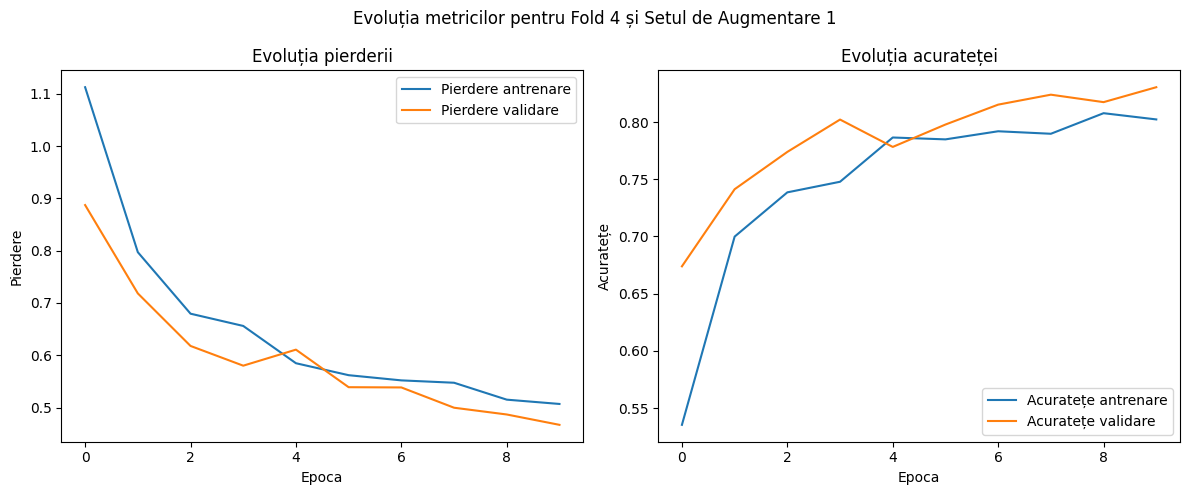


=== Fold 5/5 ===
Epoch 1/10
Train Loss: 1.1262, Train Acc: 0.5202, Val Loss: 0.9143, Val Acc: 0.6935
Epoch 2/10
Train Loss: 0.7835, Train Acc: 0.7206, Val Loss: 0.7075, Val Acc: 0.7261
Epoch 3/10
Train Loss: 0.6726, Train Acc: 0.7571, Val Loss: 0.6483, Val Acc: 0.7522
Epoch 4/10
Train Loss: 0.6246, Train Acc: 0.7669, Val Loss: 0.6382, Val Acc: 0.7543
Epoch 5/10
Train Loss: 0.5814, Train Acc: 0.7832, Val Loss: 0.5895, Val Acc: 0.7848
Epoch 6/10
Train Loss: 0.5471, Train Acc: 0.8121, Val Loss: 0.5686, Val Acc: 0.7783
Epoch 7/10
Train Loss: 0.5718, Train Acc: 0.7816, Val Loss: 0.5842, Val Acc: 0.7565
Epoch 8/10
Train Loss: 0.5329, Train Acc: 0.7936, Val Loss: 0.5595, Val Acc: 0.7783
Epoch 9/10
Train Loss: 0.5183, Train Acc: 0.8115, Val Loss: 0.5690, Val Acc: 0.7826
Epoch 10/10
Train Loss: 0.5111, Train Acc: 0.8050, Val Loss: 0.5301, Val Acc: 0.7978


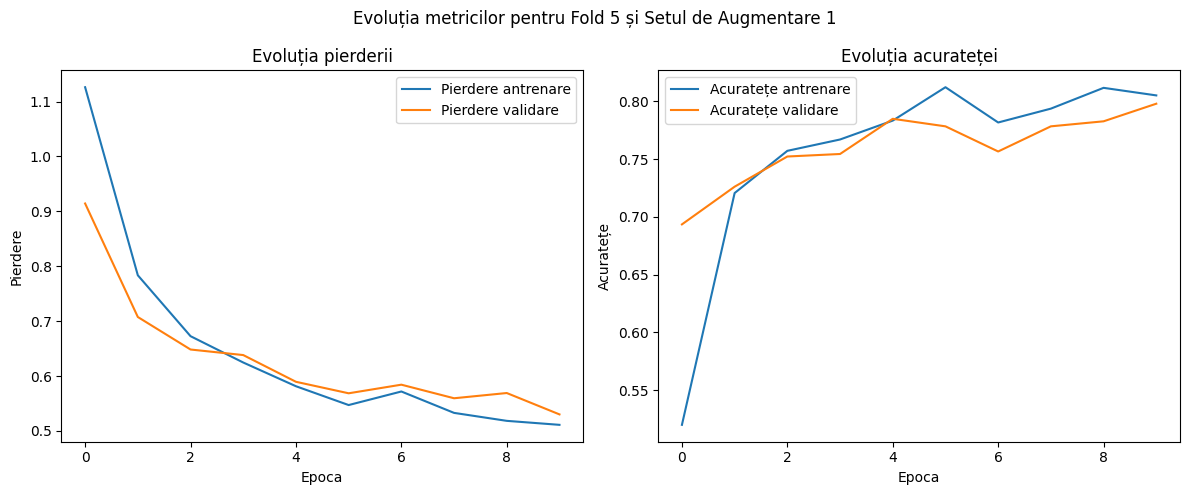


=== Setul de Augmentări 2 ===

=== Fold 1/5 ===
Epoch 1/10
Train Loss: 1.1271, Train Acc: 0.5120, Val Loss: 0.9385, Val Acc: 0.6065
Epoch 2/10
Train Loss: 0.7907, Train Acc: 0.7081, Val Loss: 0.6951, Val Acc: 0.7522
Epoch 3/10
Train Loss: 0.6920, Train Acc: 0.7527, Val Loss: 0.6080, Val Acc: 0.7826
Epoch 4/10
Train Loss: 0.6362, Train Acc: 0.7538, Val Loss: 0.6256, Val Acc: 0.7587
Epoch 5/10
Train Loss: 0.6367, Train Acc: 0.7516, Val Loss: 0.6012, Val Acc: 0.7543
Epoch 6/10
Train Loss: 0.5704, Train Acc: 0.7925, Val Loss: 0.5708, Val Acc: 0.7761
Epoch 7/10
Train Loss: 0.5758, Train Acc: 0.7772, Val Loss: 0.5624, Val Acc: 0.7739
Epoch 8/10
Train Loss: 0.5606, Train Acc: 0.7908, Val Loss: 0.5416, Val Acc: 0.8043
Epoch 9/10
Train Loss: 0.5528, Train Acc: 0.7892, Val Loss: 0.5011, Val Acc: 0.8196
Epoch 10/10
Train Loss: 0.5365, Train Acc: 0.8056, Val Loss: 0.4865, Val Acc: 0.8022


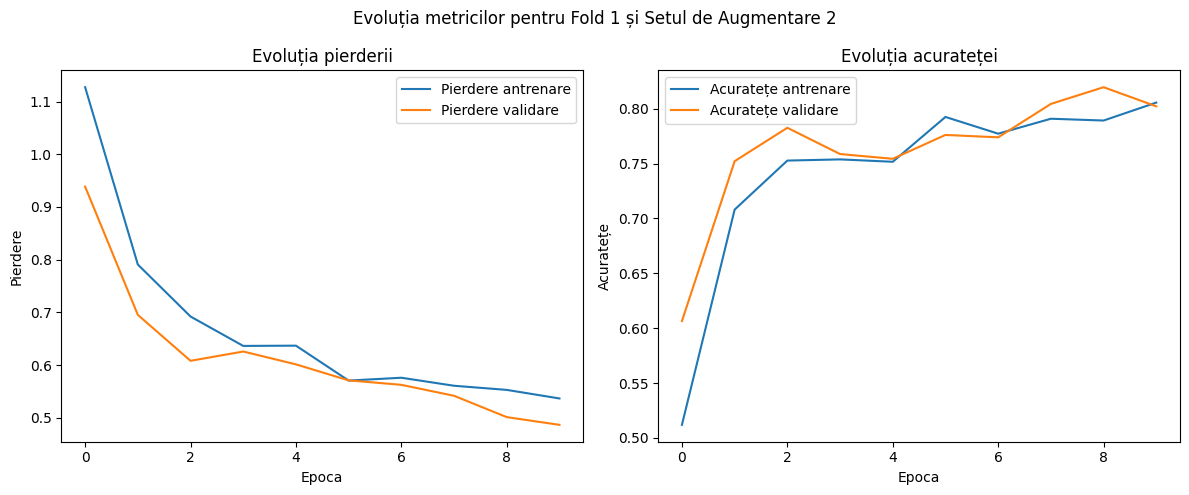


=== Fold 2/5 ===
Epoch 1/10
Train Loss: 1.0195, Train Acc: 0.5882, Val Loss: 0.8336, Val Acc: 0.7152
Epoch 2/10
Train Loss: 0.7531, Train Acc: 0.7271, Val Loss: 0.6970, Val Acc: 0.7283
Epoch 3/10
Train Loss: 0.6824, Train Acc: 0.7544, Val Loss: 0.5718, Val Acc: 0.7804
Epoch 4/10
Train Loss: 0.6281, Train Acc: 0.7680, Val Loss: 0.5803, Val Acc: 0.7717
Epoch 5/10
Train Loss: 0.5868, Train Acc: 0.7734, Val Loss: 0.5856, Val Acc: 0.7761
Epoch 6/10
Train Loss: 0.5776, Train Acc: 0.7805, Val Loss: 0.5355, Val Acc: 0.8087
Epoch 7/10
Train Loss: 0.5408, Train Acc: 0.7914, Val Loss: 0.5384, Val Acc: 0.7891
Epoch 8/10
Train Loss: 0.5158, Train Acc: 0.8061, Val Loss: 0.5087, Val Acc: 0.8000
Epoch 9/10
Train Loss: 0.5472, Train Acc: 0.7849, Val Loss: 0.5278, Val Acc: 0.7848
Epoch 10/10
Train Loss: 0.5161, Train Acc: 0.8012, Val Loss: 0.4835, Val Acc: 0.8152


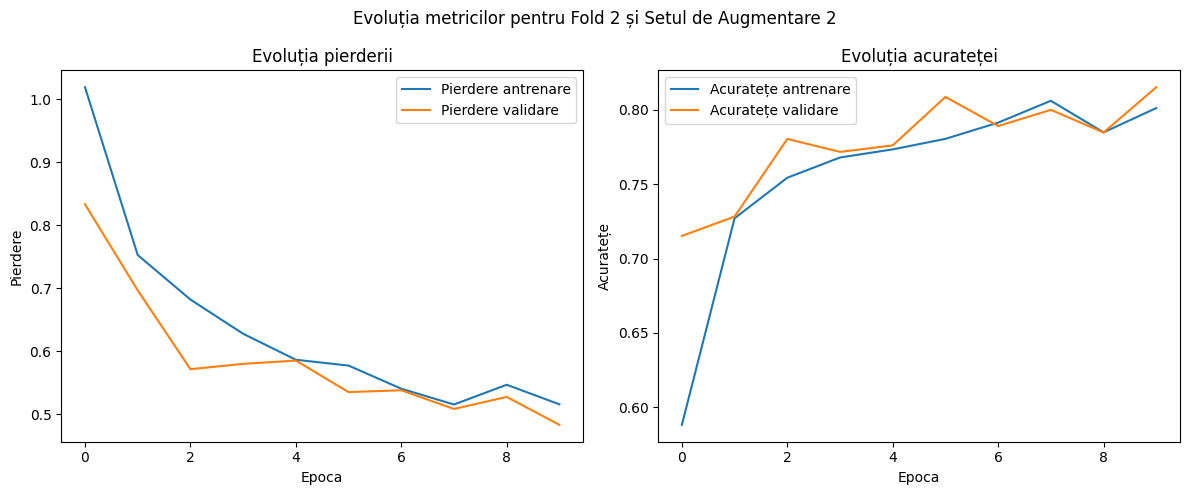


=== Fold 3/5 ===
Epoch 1/10
Train Loss: 1.1172, Train Acc: 0.5316, Val Loss: 0.8484, Val Acc: 0.6761
Epoch 2/10
Train Loss: 0.7950, Train Acc: 0.6961, Val Loss: 0.6692, Val Acc: 0.7761
Epoch 3/10
Train Loss: 0.6821, Train Acc: 0.7484, Val Loss: 0.6223, Val Acc: 0.7783
Epoch 4/10
Train Loss: 0.6320, Train Acc: 0.7707, Val Loss: 0.6179, Val Acc: 0.7696
Epoch 5/10
Train Loss: 0.6137, Train Acc: 0.7751, Val Loss: 0.5617, Val Acc: 0.7913
Epoch 6/10
Train Loss: 0.5800, Train Acc: 0.7870, Val Loss: 0.5205, Val Acc: 0.8478
Epoch 7/10
Train Loss: 0.5555, Train Acc: 0.7919, Val Loss: 0.5110, Val Acc: 0.8261
Epoch 8/10
Train Loss: 0.5419, Train Acc: 0.7778, Val Loss: 0.4990, Val Acc: 0.8348
Epoch 9/10
Train Loss: 0.5420, Train Acc: 0.8007, Val Loss: 0.4872, Val Acc: 0.8239
Epoch 10/10
Train Loss: 0.5155, Train Acc: 0.8039, Val Loss: 0.4915, Val Acc: 0.8196


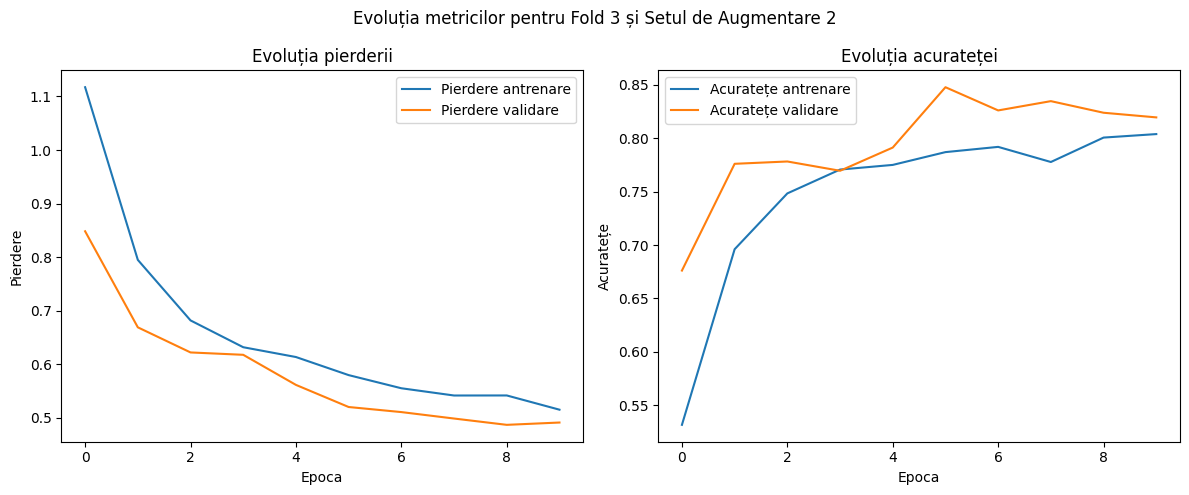


=== Fold 4/5 ===
Epoch 1/10
Train Loss: 1.1468, Train Acc: 0.5300, Val Loss: 0.9262, Val Acc: 0.6457
Epoch 2/10
Train Loss: 0.7969, Train Acc: 0.7141, Val Loss: 0.7250, Val Acc: 0.7326
Epoch 3/10
Train Loss: 0.6971, Train Acc: 0.7402, Val Loss: 0.6595, Val Acc: 0.7674
Epoch 4/10
Train Loss: 0.6415, Train Acc: 0.7636, Val Loss: 0.5826, Val Acc: 0.7783
Epoch 5/10
Train Loss: 0.6084, Train Acc: 0.7729, Val Loss: 0.5361, Val Acc: 0.8109
Epoch 6/10
Train Loss: 0.5761, Train Acc: 0.7761, Val Loss: 0.5271, Val Acc: 0.8043
Epoch 7/10
Train Loss: 0.5546, Train Acc: 0.8001, Val Loss: 0.5603, Val Acc: 0.7717
Epoch 8/10
Train Loss: 0.5290, Train Acc: 0.8023, Val Loss: 0.5175, Val Acc: 0.8087
Epoch 9/10
Train Loss: 0.5306, Train Acc: 0.8007, Val Loss: 0.5026, Val Acc: 0.8152
Epoch 10/10
Train Loss: 0.5092, Train Acc: 0.8034, Val Loss: 0.4837, Val Acc: 0.8348


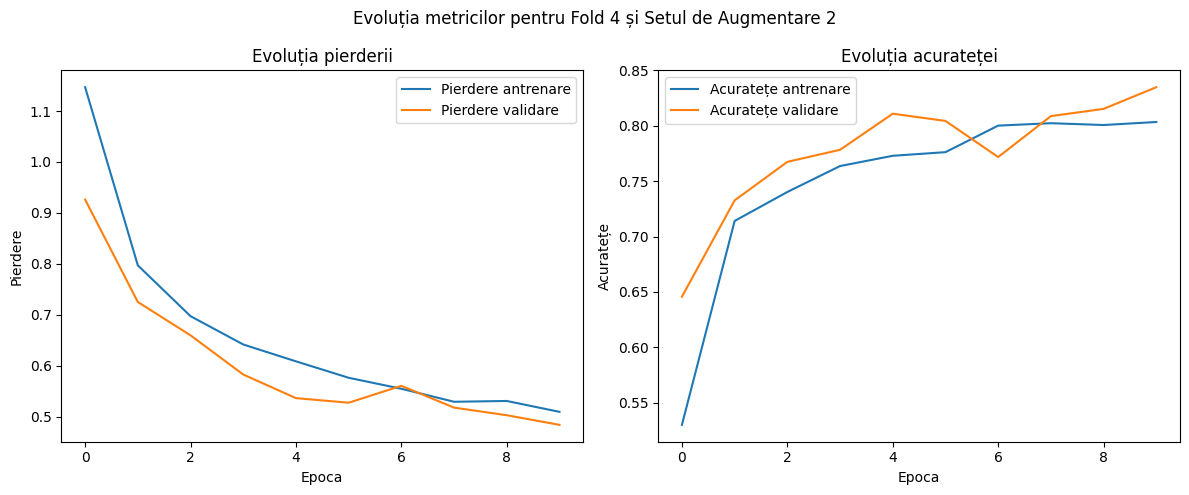


=== Fold 5/5 ===
Epoch 1/10
Train Loss: 1.0588, Train Acc: 0.5572, Val Loss: 0.9458, Val Acc: 0.6478
Epoch 2/10
Train Loss: 0.7732, Train Acc: 0.7184, Val Loss: 0.7495, Val Acc: 0.7087
Epoch 3/10
Train Loss: 0.6917, Train Acc: 0.7375, Val Loss: 0.6526, Val Acc: 0.7000
Epoch 4/10
Train Loss: 0.6395, Train Acc: 0.7593, Val Loss: 0.6114, Val Acc: 0.7739
Epoch 5/10
Train Loss: 0.5905, Train Acc: 0.7827, Val Loss: 0.5835, Val Acc: 0.7804
Epoch 6/10
Train Loss: 0.5720, Train Acc: 0.7778, Val Loss: 0.5935, Val Acc: 0.7630
Epoch 7/10
Train Loss: 0.5460, Train Acc: 0.8045, Val Loss: 0.5831, Val Acc: 0.7848
Epoch 8/10
Train Loss: 0.5345, Train Acc: 0.7958, Val Loss: 0.5855, Val Acc: 0.7935
Epoch 9/10
Train Loss: 0.5034, Train Acc: 0.8268, Val Loss: 0.5607, Val Acc: 0.7935
Epoch 10/10
Train Loss: 0.5150, Train Acc: 0.8132, Val Loss: 0.5682, Val Acc: 0.7761


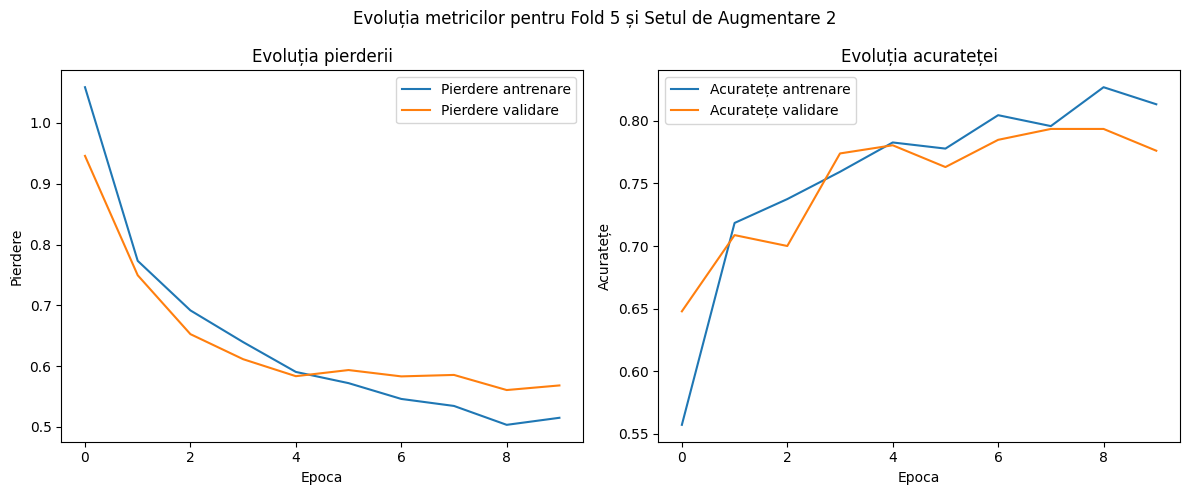


=== Setul de Augmentări 3 ===

=== Fold 1/5 ===
Epoch 1/10
Train Loss: 1.0236, Train Acc: 0.5833, Val Loss: 0.8648, Val Acc: 0.7065
Epoch 2/10
Train Loss: 0.7206, Train Acc: 0.7402, Val Loss: 0.6624, Val Acc: 0.7522
Epoch 3/10
Train Loss: 0.6440, Train Acc: 0.7538, Val Loss: 0.6278, Val Acc: 0.7543
Epoch 4/10
Train Loss: 0.5871, Train Acc: 0.7789, Val Loss: 0.5801, Val Acc: 0.7674
Epoch 5/10
Train Loss: 0.5670, Train Acc: 0.7712, Val Loss: 0.5461, Val Acc: 0.7978
Epoch 6/10
Train Loss: 0.5314, Train Acc: 0.7941, Val Loss: 0.5753, Val Acc: 0.7870
Epoch 7/10
Train Loss: 0.5198, Train Acc: 0.8061, Val Loss: 0.5041, Val Acc: 0.8152
Epoch 8/10
Train Loss: 0.5059, Train Acc: 0.8121, Val Loss: 0.4967, Val Acc: 0.7848
Epoch 9/10
Train Loss: 0.4993, Train Acc: 0.8115, Val Loss: 0.4779, Val Acc: 0.8130
Epoch 10/10
Train Loss: 0.4942, Train Acc: 0.8148, Val Loss: 0.4703, Val Acc: 0.8174


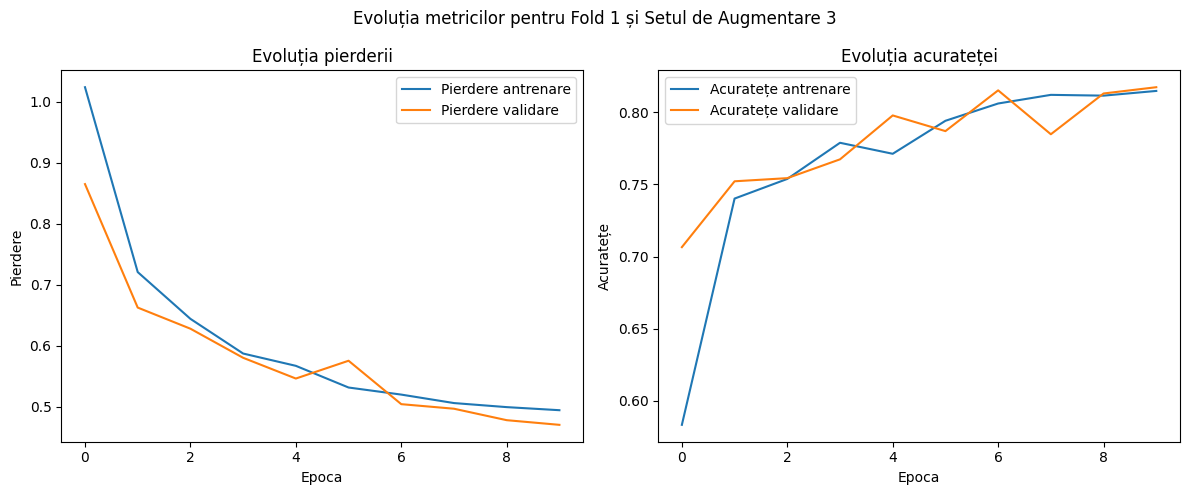


=== Fold 2/5 ===
Epoch 1/10
Train Loss: 1.0901, Train Acc: 0.5289, Val Loss: 0.8314, Val Acc: 0.6783
Epoch 2/10
Train Loss: 0.7345, Train Acc: 0.7369, Val Loss: 0.6399, Val Acc: 0.7717
Epoch 3/10
Train Loss: 0.6470, Train Acc: 0.7816, Val Loss: 0.5550, Val Acc: 0.7935
Epoch 4/10
Train Loss: 0.5861, Train Acc: 0.7941, Val Loss: 0.5094, Val Acc: 0.8130
Epoch 5/10
Train Loss: 0.5413, Train Acc: 0.8045, Val Loss: 0.4931, Val Acc: 0.8304
Epoch 6/10
Train Loss: 0.5147, Train Acc: 0.8121, Val Loss: 0.4660, Val Acc: 0.8348
Epoch 7/10
Train Loss: 0.4978, Train Acc: 0.8186, Val Loss: 0.4752, Val Acc: 0.8130
Epoch 8/10
Train Loss: 0.4827, Train Acc: 0.8219, Val Loss: 0.4597, Val Acc: 0.8283
Epoch 9/10
Train Loss: 0.4758, Train Acc: 0.8203, Val Loss: 0.4220, Val Acc: 0.8413
Epoch 10/10
Train Loss: 0.4570, Train Acc: 0.8355, Val Loss: 0.4569, Val Acc: 0.8283


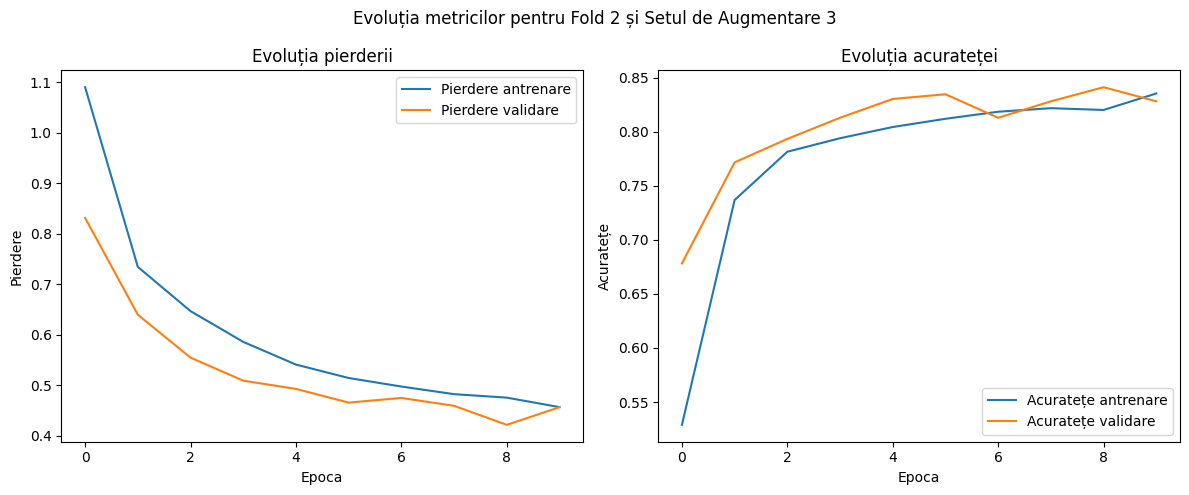


=== Fold 3/5 ===
Epoch 1/10
Train Loss: 1.0456, Train Acc: 0.5724, Val Loss: 0.8449, Val Acc: 0.7087
Epoch 2/10
Train Loss: 0.7424, Train Acc: 0.7288, Val Loss: 0.6777, Val Acc: 0.7543
Epoch 3/10
Train Loss: 0.6447, Train Acc: 0.7642, Val Loss: 0.5788, Val Acc: 0.7870
Epoch 4/10
Train Loss: 0.5968, Train Acc: 0.7734, Val Loss: 0.5381, Val Acc: 0.7957
Epoch 5/10
Train Loss: 0.5555, Train Acc: 0.7908, Val Loss: 0.5173, Val Acc: 0.8239
Epoch 6/10
Train Loss: 0.5276, Train Acc: 0.8001, Val Loss: 0.4831, Val Acc: 0.8370
Epoch 7/10
Train Loss: 0.5100, Train Acc: 0.8126, Val Loss: 0.4622, Val Acc: 0.8565
Epoch 8/10
Train Loss: 0.4988, Train Acc: 0.8186, Val Loss: 0.4925, Val Acc: 0.8109
Epoch 9/10
Train Loss: 0.4881, Train Acc: 0.8192, Val Loss: 0.4644, Val Acc: 0.8239
Epoch 10/10
Train Loss: 0.4729, Train Acc: 0.8197, Val Loss: 0.4722, Val Acc: 0.8152


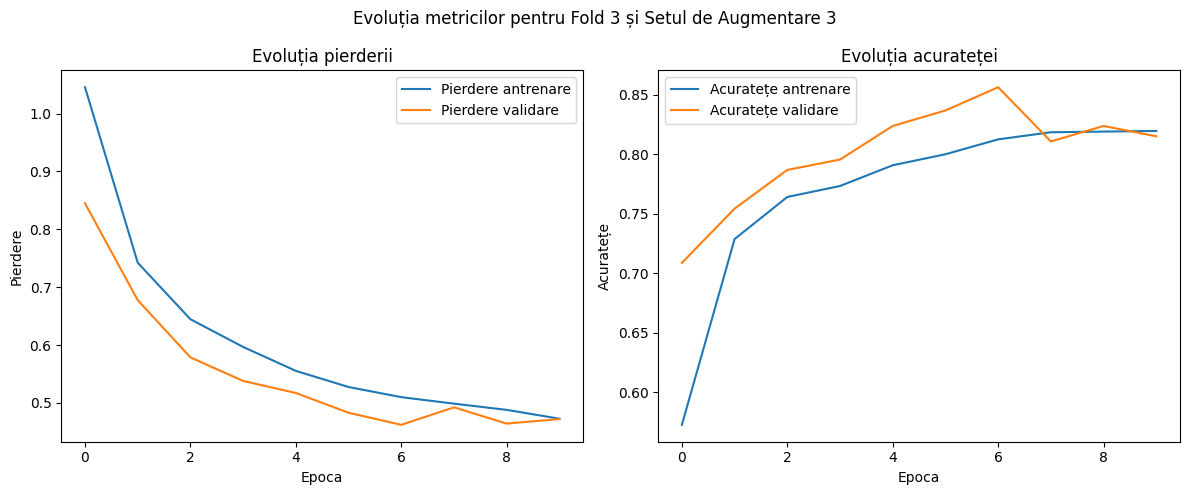


=== Fold 4/5 ===
Epoch 1/10
Train Loss: 1.0509, Train Acc: 0.5795, Val Loss: 0.8734, Val Acc: 0.6870
Epoch 2/10
Train Loss: 0.7226, Train Acc: 0.7446, Val Loss: 0.6192, Val Acc: 0.7935
Epoch 3/10
Train Loss: 0.6406, Train Acc: 0.7565, Val Loss: 0.5683, Val Acc: 0.8087
Epoch 4/10
Train Loss: 0.5706, Train Acc: 0.7936, Val Loss: 0.5628, Val Acc: 0.7870
Epoch 5/10
Train Loss: 0.5457, Train Acc: 0.8028, Val Loss: 0.5235, Val Acc: 0.8087
Epoch 6/10
Train Loss: 0.5133, Train Acc: 0.8126, Val Loss: 0.4671, Val Acc: 0.8196
Epoch 7/10
Train Loss: 0.5052, Train Acc: 0.8137, Val Loss: 0.4908, Val Acc: 0.8217
Epoch 8/10
Train Loss: 0.4797, Train Acc: 0.8279, Val Loss: 0.4588, Val Acc: 0.8304
Epoch 9/10
Train Loss: 0.4798, Train Acc: 0.8235, Val Loss: 0.4382, Val Acc: 0.8239
Epoch 10/10
Train Loss: 0.4533, Train Acc: 0.8339, Val Loss: 0.4568, Val Acc: 0.8304


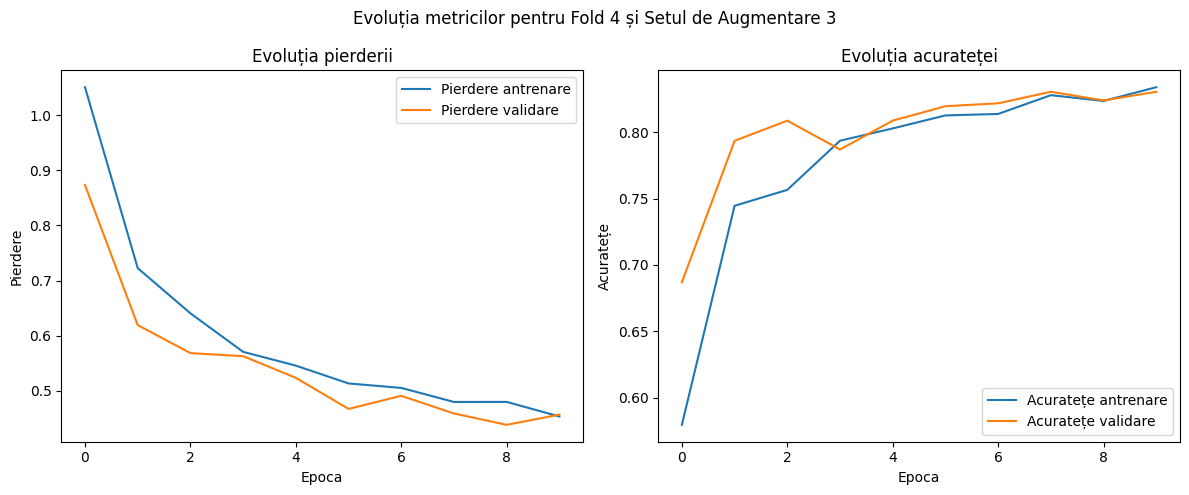


=== Fold 5/5 ===
Epoch 1/10
Train Loss: 1.0634, Train Acc: 0.5714, Val Loss: 0.8586, Val Acc: 0.6652
Epoch 2/10
Train Loss: 0.7406, Train Acc: 0.7331, Val Loss: 0.6653, Val Acc: 0.7652
Epoch 3/10
Train Loss: 0.6220, Train Acc: 0.7642, Val Loss: 0.6297, Val Acc: 0.7630
Epoch 4/10
Train Loss: 0.5861, Train Acc: 0.7974, Val Loss: 0.5667, Val Acc: 0.7696
Epoch 5/10
Train Loss: 0.5376, Train Acc: 0.8110, Val Loss: 0.5497, Val Acc: 0.8065
Epoch 6/10
Train Loss: 0.5206, Train Acc: 0.8083, Val Loss: 0.4988, Val Acc: 0.8130
Epoch 7/10
Train Loss: 0.4846, Train Acc: 0.8268, Val Loss: 0.5339, Val Acc: 0.7978
Epoch 8/10
Train Loss: 0.4704, Train Acc: 0.8219, Val Loss: 0.5027, Val Acc: 0.8152
Epoch 9/10
Train Loss: 0.4844, Train Acc: 0.8159, Val Loss: 0.5157, Val Acc: 0.8130
Epoch 10/10
Train Loss: 0.4575, Train Acc: 0.8350, Val Loss: 0.4461, Val Acc: 0.8152


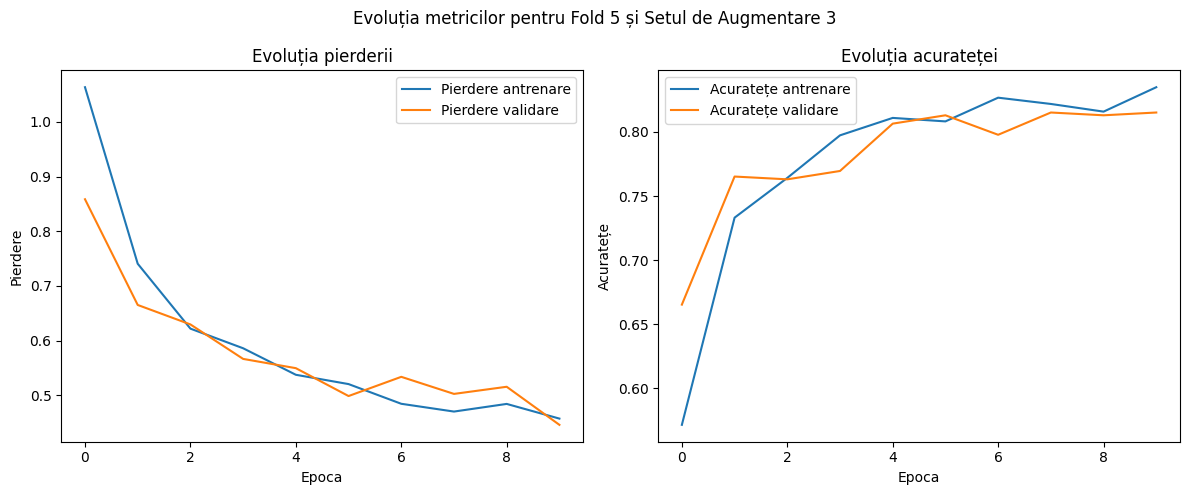


=== Rezumatul K-Fold ===

Metrici pentru VAL:
Accuracy: Media = 0.8164, Deviația standard = 0.0285
Precision: Media = 0.8196, Deviația standard = 0.0295
Recall: Media = 0.8164, Deviația standard = 0.0285
F1_score: Media = 0.8141, Deviația standard = 0.0293

Metrici pentru TEST:
Accuracy: Media = 0.8141, Deviația standard = 0.0210
Precision: Media = 0.8162, Deviația standard = 0.0197
Recall: Media = 0.8141, Deviația standard = 0.0210
F1_score: Media = 0.8122, Deviația standard = 0.0216


In [51]:
k_fold_cross_validation(dataset, k=5, num_epochs=10, learning_rate=0.001, batch_size=32, device="cuda", use_augmentation=True)